In [ ]:
#tfds.as_dataframe(train_df.head())

# !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
# !tar -xvf food-101.tar.gz
! pip install tensorflow_datasets

In [3]:
import numpy as np
import keras
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential, load_model, Model
from keras.layers import Dropout, Flatten, Dense, Input, GlobalAveragePooling2D
from keras import applications
from keras.applications import ResNet152V2
from keras.utils.np_utils import to_categorical
from tensorflow.keras import regularizers
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau
from keras.optimizers import Adam  
import keras,os,re,math,itertools
import matplotlib.pyplot as plt
import keras.backend as K
from ipywidgets import interact, interactive, fixed
from sklearn.metrics import confusion_matrix
from keras.optimizers import SGD
import tensorflow_datasets as tfds
import tensorflow as tf
import collections
from tensorflow.keras.applications.inception_v3 import InceptionV3
print(tf.config.experimental.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]


In [2]:
# read data block


# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [ ]:
prepare_data('food-101/meta/test.txt', 'food-101/images', 'test')

In [4]:
# Check how many files are in the train folder
print("Total number of samples in train folder")
!find train -type d -or -type f -printf '.' | wc -c

# Check how many files are in the test folder
print("Total number of samples in test folder")
!find test -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
75750
Total number of samples in test folder
25250


In [5]:
class_to_ix = {}
ix_to_class = {}
with open('food-101/meta/classes.txt', 'r') as txt:
    classes = [l.strip() for l in txt.readlines()]
    class_to_ix = dict(zip(classes, range(len(classes))))
    ix_to_class = dict(zip(range(len(classes)), classes))
    class_to_ix = {v: k for k, v in ix_to_class.items()}
sorted_class_to_ix = collections.OrderedDict(sorted(class_to_ix.items()))

In [ ]:
sorted_class_to_ix

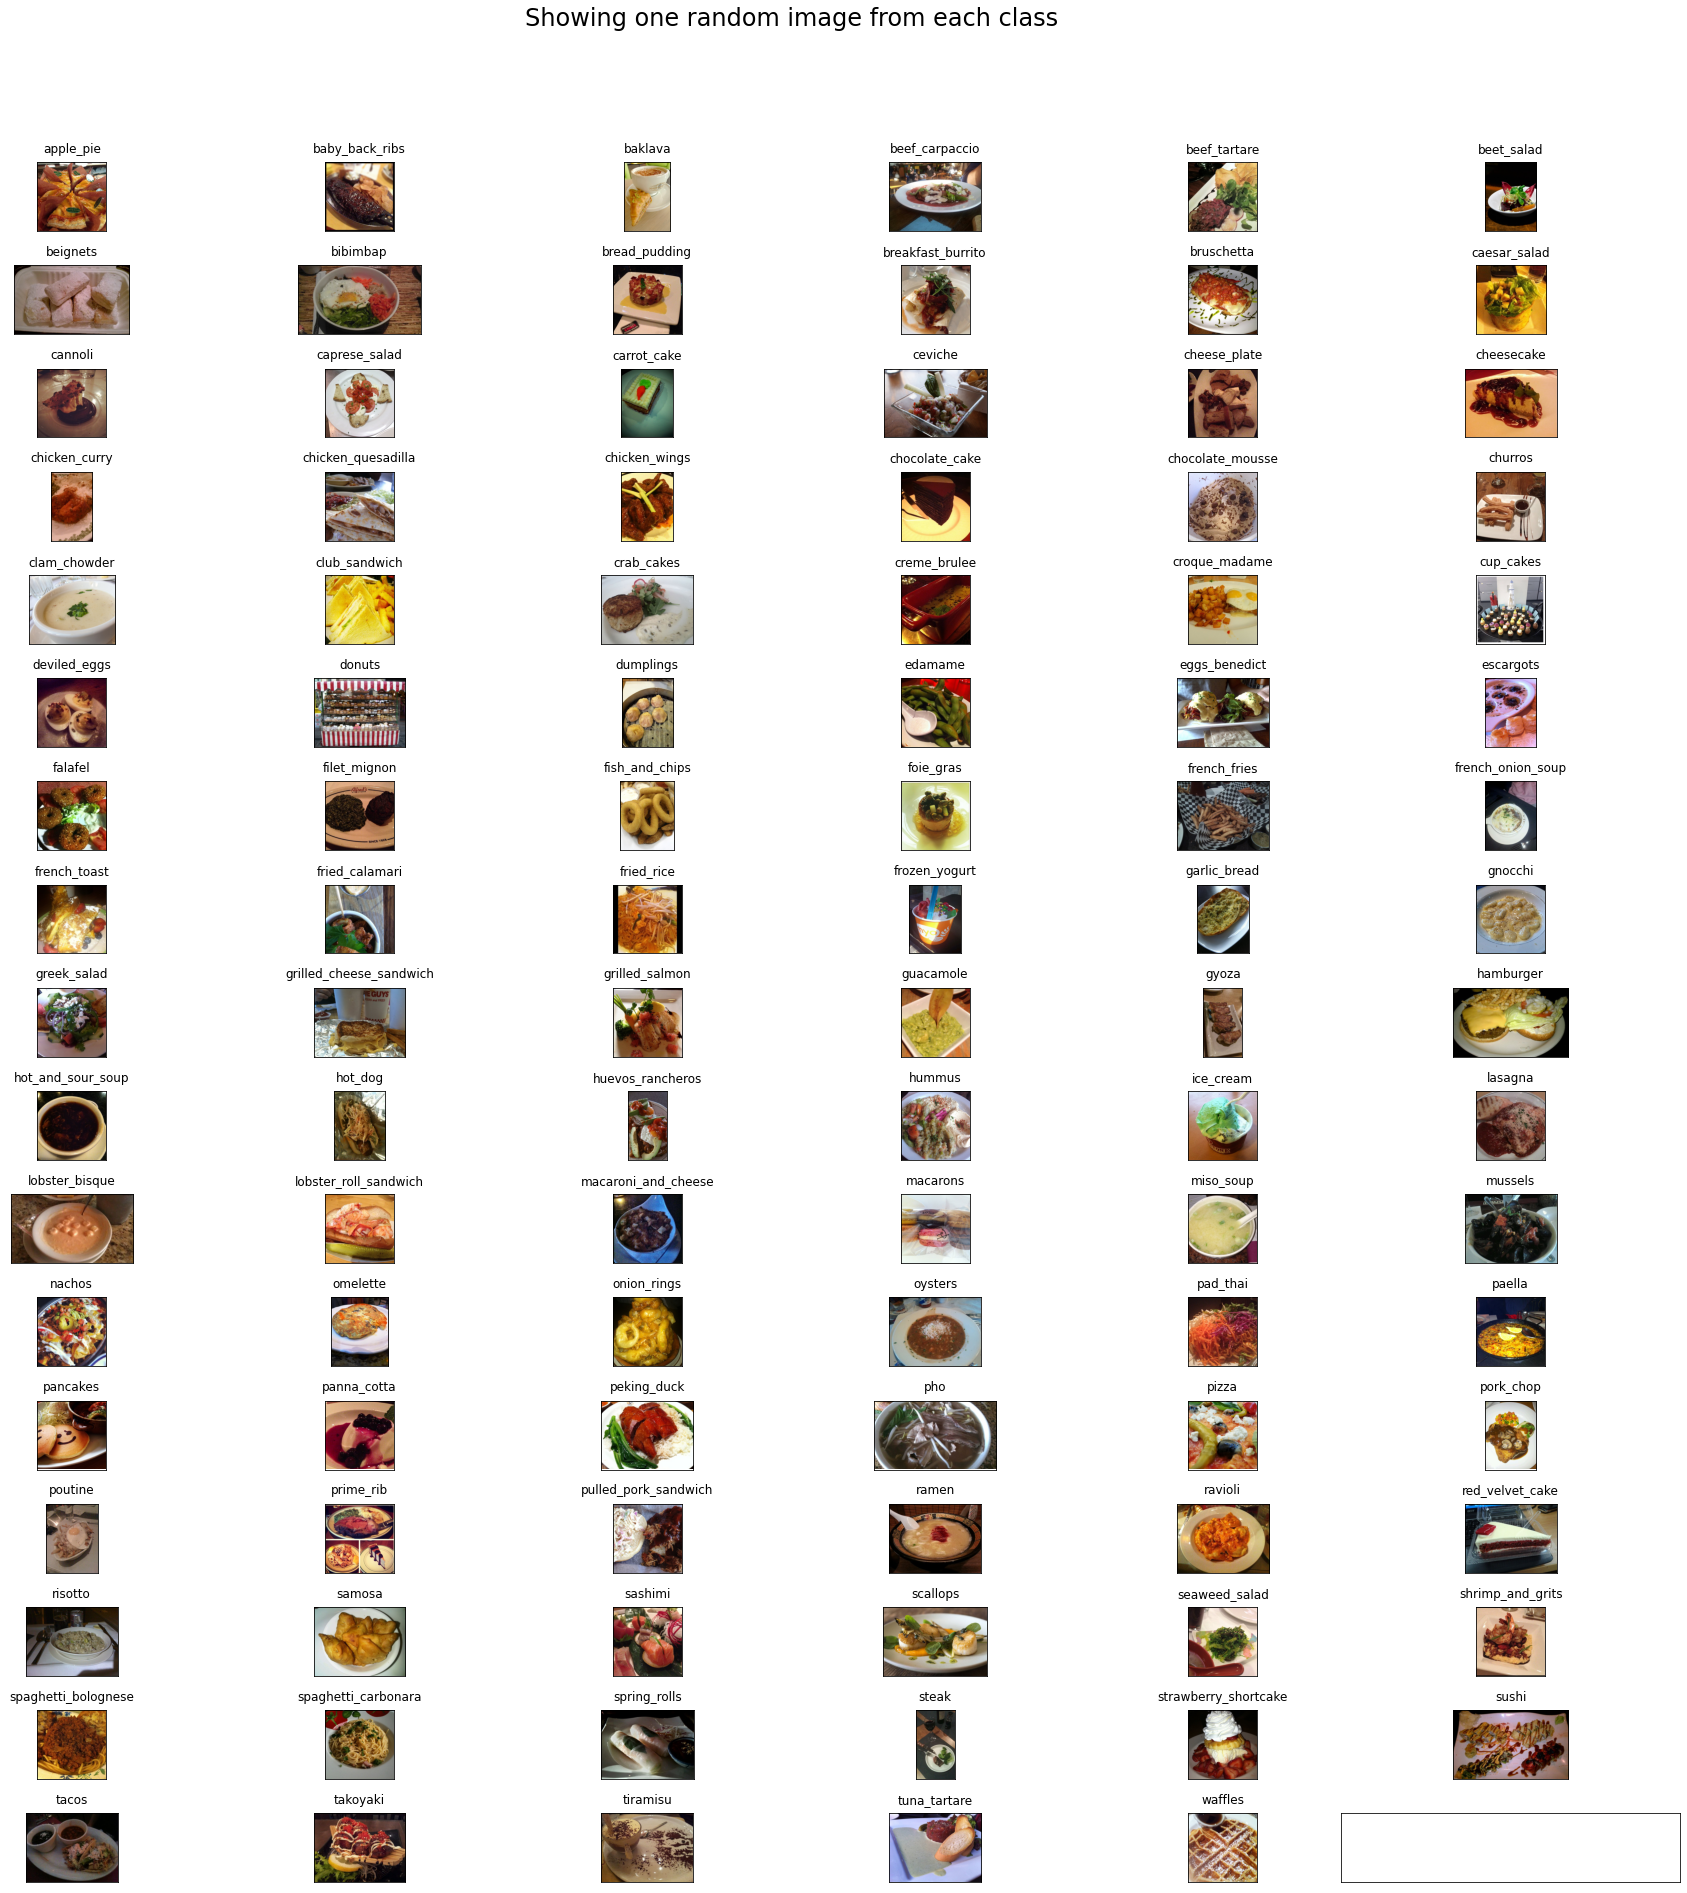

In [7]:
# Visualize the data, showing one image per class from 101 classes
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    if food_selected == '.DS_Store':
        continue
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()
# https://matplotlib.org/users/tight_layout_guide.html

In [8]:
current_demo_classes = ['pizza', 'burger', 'fries', 'waffles', 'fried_rice', 'oysters']

In [9]:
def schedule(epoch):
    if epoch < 15:
        return .01
    elif epoch < 28:
        return .002
    else:
        return .0004
lr_scheduler = LearningRateScheduler(schedule)

In [10]:
strategy = tf.distribute.MirroredStrategy(["GPU:0", "GPU:1", "GPU:2", "GPU:3"])
with strategy.scope():
    # apply functions to the data to improve training
    img_width, img_height = 299, 299
    num_of_classes = 101

    # number of epochs to train top model
    epochs = 20

    # batch size used by flow_from_directory and predict_generator, try 128 if possible
    batch_size = 64
    #important hyper-parameters
    metrics = ['accuracy']

    datagenTrain = ImageDataGenerator(
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False, # randomly flip images
        zoom_range=[.8, 1.2],
        channel_shift_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range = 0.2,
        fill_mode='nearest',
        preprocessing_function = tf.keras.applications.inception_v3.preprocess_input) #preprocess_input is the preprocessing function used in 
                                                    #original resnet152V2 model

    generatorTrain = datagenTrain.flow_from_directory(
        'train',
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)
    
    classes = generatorTrain.class_indices
  
    #test_datagen = ImageDataGenerator(zoom_range=[.8,1.2], horizontal_flip=True, vertical_flip=False)
    # just rescale images for validation
    test_datagen = ImageDataGenerator(zoom_range=[.8,1.2])

    validation_generator = test_datagen.flow_from_directory(
        'test',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)
    
    
    resnet = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(299, 299, 3)))
    x = resnet.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128,activation='relu')(x)
    x = Dropout(0.2)(x)

    predictions = Dense(101,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

#     model = Model(inputs=resnet.input, outputs=predictions)
    #model = load_model(filepath='best_model_3class.hdf5')
    # load our saved model. 
    model.compile(optimizer=SGD(lr=0.002, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
    
    checkpointer = ModelCheckpoint(filepath='best_model_3class.hdf5', verbose=1, save_best_only=True)
    csv_logger = CSVLogger('history_3class.log')

    nb_train_samples = 75750
    nb_validation_samples = 25250
    batch_size = 128

#     history = model.fit_generator(generatorTrain,
#                         #steps_per_epoch = nb_train_samples // batch_size,
#                         nb_val_samples = nb_validation_samples,
#                         validation_data=validation_generator,
#                         #validation_steps=nb_validation_samples // batch_size,
#                         samples_per_epoch = nb_train_samples / 25,
#                         epochs=30,
#                         verbose=1,
#                         callbacks=[csv_logger, checkpointer, lr_scheduler])

    history = model.fit(generatorTrain,
                        steps_per_epoch = nb_train_samples // batch_size,
                        batch_size= batch_size,
                        epochs = 50,
                        validation_data = validation_generator,
                        verbose = 1,
                        callbacks = [csv_logger, checkpointer, lr_scheduler],
                        )

    model.save('model_trained_class.hdf5')



INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost

KeyboardInterrupt: 

In [ ]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

In [ ]:
plot_accuracy(history,'FOOD101-Inceptionv3')
plot_loss(history,'FOOD101-Inceptionv3')

In [ ]:
# function we can use to predict the class of images we pass in from best place for
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255.                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

In [ ]:
# just an example
try:
    images = []
    images.append('applepie.jpg')
    images.append('pizza.jpg')
    images.append('omelette.jpg')
    predict_class(model_best, images, True)
except:
    print('failed')

In [ ]:
# function to show heatmap of features for images
# pretty crazy to see and would look cool in demo
def get_attribution(food):
    img = image.load_img(food, target_size=(299, 299))
    img = image.img_to_array(img) 
    img /= 255. 
    f,ax = plt.subplots(1,3, figsize=(15,15))
    ax[0].imshow(img)
    
    img = np.expand_dims(img, axis=0) 
    
    preds = model.predict(img)
    class_id = np.argmax(preds[0])
    ax[0].set_title("Input Image")
    class_output = model.output[:, class_id]
    last_conv_layer = model.get_layer("mixed10")
    
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([img])
    for i in range(2048):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    ax[1].imshow(heatmap)
    ax[1].set_title("Heat map")
    
    
    act_img = cv2.imread(food)
    heatmap = cv2.resize(heatmap, (act_img.shape[1], act_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(act_img, 0.6, heatmap, 0.4, 0)
    cv2.imwrite('classactivation.png', superimposed)
    img_act = image.load_img('classactivation.png', target_size=(299, 299))
    ax[2].imshow(img_act)
    ax[2].set_title("Class Activation")
    plt.show()
    return preds

In [ ]:
pred = get_attribution('applepie.jpg')
print("Here are softmax predictions..",pred)